In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.svm import LinearSVC
sns.set()

Загрузка данные сета.

In [149]:
credits = pd.read_csv('crx.data',
                      names=["Gender", "Age", "Debt", "Married", "BankCustomer", "EducationLevel", "Ethnicity",
                             "YearsEmployed", "PriorDefault", "Employed", "CreditScore", "DriversLicense", "Citizen",
                             "ZipCode", "Income", "ApprovalStatus"])
#Смотрим основные параметры.

In [150]:
credits["ApprovalStatus"] = np.where(credits["ApprovalStatus"] == "+", 1, 0)

In [151]:
render_columns = credits.columns
render_columns = render_columns.drop(
    labels=["Age", "Debt", "YearsEmployed", "CreditScore", "ZipCode", "Income", "ApprovalStatus"])
for column in render_columns:
    encoder = preprocessing.LabelEncoder()
    credits[column] = encoder.fit_transform(credits[column])

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [152]:
credits["Married"].value_counts()

2    519
3    163
0      6
1      2
Name: Married, dtype: int64

In [153]:
credits.head(100)

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,2,30.83,0.000,2,1,13,8,1.250,1,1,1,0,0,00202,0,1
1,1,58.67,4.460,2,1,11,4,3.040,1,1,6,0,0,00043,560,1
2,1,24.50,0.500,2,1,11,4,1.500,1,0,0,0,0,00280,824,1
3,2,27.83,1.540,2,1,13,8,3.750,1,1,5,1,0,00100,3,1
4,2,20.17,5.625,2,1,13,8,1.710,1,0,0,0,2,00120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,28.58,3.540,2,1,7,1,0.500,1,0,0,1,0,00171,0,0
96,2,23.00,0.625,3,3,1,8,0.125,1,0,0,0,0,00180,1,0
97,2,?,0.500,2,1,2,1,0.835,1,0,0,1,2,00320,0,0
98,1,22.50,11.000,3,3,11,8,3.000,1,0,0,1,0,00268,0,0


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [154]:
credits.count()

Gender            690
Age               690
Debt              690
Married           690
BankCustomer      690
EducationLevel    690
Ethnicity         690
YearsEmployed     690
PriorDefault      690
Employed          690
CreditScore       690
DriversLicense    690
Citizen           690
ZipCode           690
Income            690
ApprovalStatus    690
dtype: int64

В процентном соотношении.

In [155]:
for col in credits.columns:
    pct_missing = np.mean(credits[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {credits[col].min()}     max:{credits[col].max()}')

Gender - 0.0     min: 0     max:2
Age - 0.0     min: 13.75     max:?
Debt - 0.0     min: 0.0     max:28.0
Married - 0.0     min: 0     max:3
BankCustomer - 0.0     min: 0     max:3
EducationLevel - 0.0     min: 0     max:14
Ethnicity - 0.0     min: 0     max:9
YearsEmployed - 0.0     min: 0.0     max:28.5
PriorDefault - 0.0     min: 0     max:1
Employed - 0.0     min: 0     max:1
CreditScore - 0.0     min: 0     max:67
DriversLicense - 0.0     min: 0     max:1
Citizen - 0.0     min: 0     max:2
ZipCode - 0.0     min: 00000     max:?
Income - 0.0     min: 0     max:100000
ApprovalStatus - 0.0     min: 0     max:1


In [156]:
credits.describe()

,Gender,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,ApprovalStatus
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000
mean,1.660870,4.758725,2.215942,1.466667,6.672464,5.994203,2.223406,0.523188,0.427536,2.40000,0.457971,0.176812,1017.385507,0.444928
std,0.509195,4.978163,0.477087,0.860126,4.320266,2.594506,3.346513,0.499824,0.495080,4.86294,0.498592,0.557869,5210.102598,0.497318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,2.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.750000,2.000000,1.000000,6.000000,8.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000
75%,2.000000,7.207500,2.000000,1.000000,11.000000,8.000000,2.625000,1.000000,1.000000,3.00000,1.000000,0.000000,395.500000,1.000000
max,2.000000,28.000000,3.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,2.000000,100000.000000,1.000000


Создаём карту корреляций.

/tmp/ipykernel_5173/481190486.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = credits.corr()


<AxesSubplot: >

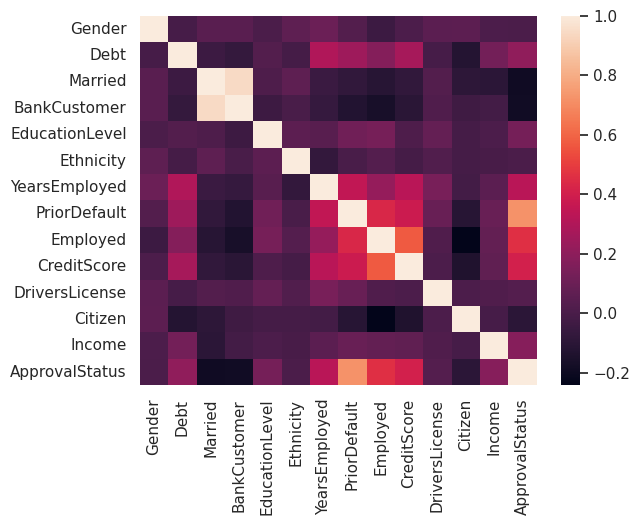

In [157]:
corr = credits.corr()
sns.heatmap(corr)

По талице корреляции видно что на статус кредита напрямую влияют такие столбцы как: PriorDefault, CreditScore, Employed. Все остальные можем откинуть за неинформативность.

In [158]:
credit_value = credits[["PriorDefault", "Employed", "CreditScore", "ApprovalStatus"]]

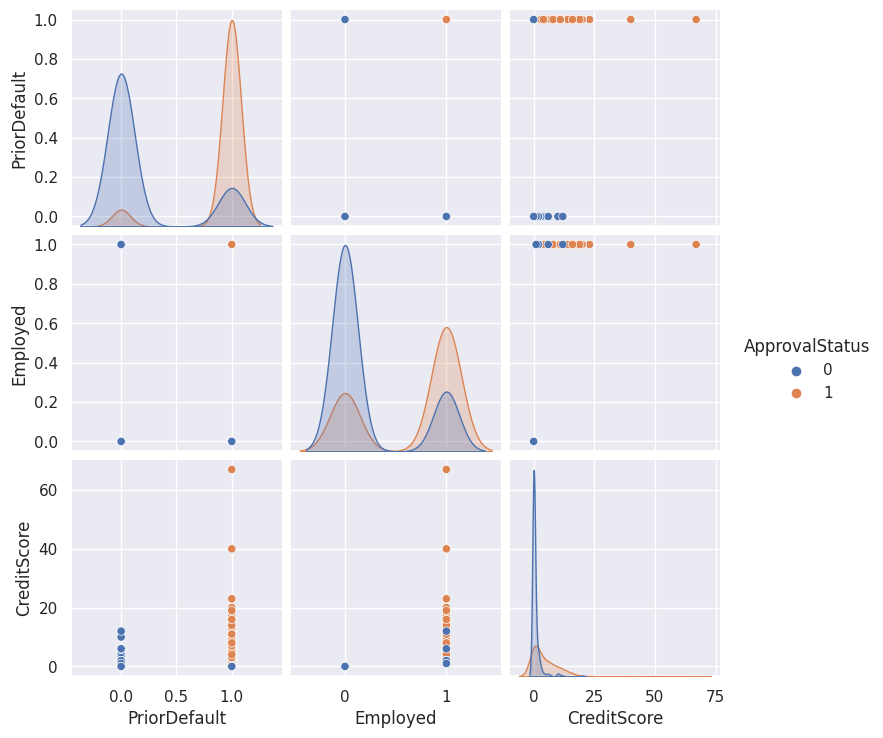

In [159]:
sns.pairplot(
    credit_value,
    hue="ApprovalStatus");

Осталось три фичи которые могут с большой вероятностью предсказать выдачу кредита, на графиках видно чёткое разделение по группам.

Можно сделать новую фичу которая будет некоторым образом предсказывать дадут ли кредит.

/tmp/ipykernel_5173/592594542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_value["NewScore"] = 2-credit_value["PriorDefault"]-credit_value["Employed"]


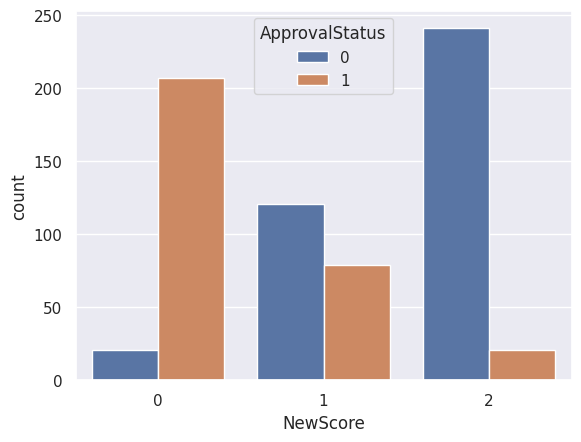

In [160]:
credit_value["NewScore"] = 2-credit_value["PriorDefault"]-credit_value["Employed"]
sns.countplot(x="NewScore", hue="ApprovalStatus", data=credit_value);

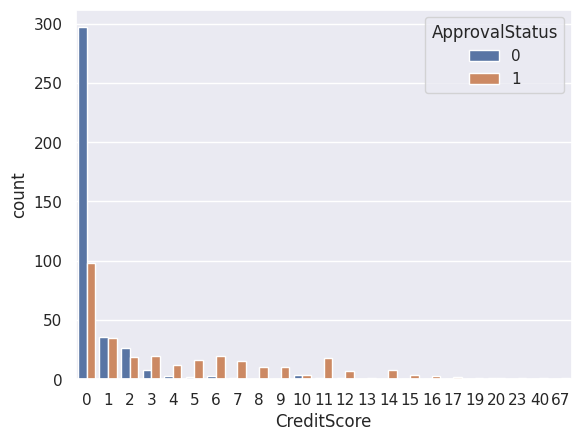

In [161]:
sns.countplot(x="CreditScore", hue="ApprovalStatus", data=credit_value);

Так же видна зависисимость что чем больше будет CreditScore тем вероятнее то что будет выдан кредит.

In [162]:
credit_value.shape
target = credit_value["ApprovalStatus"]
credit_value.drop(columns=["ApprovalStatus"])

,PriorDefault,Employed,CreditScore,NewScore
0,1,1,1,0
1,1,1,6,0
2,1,0,0,1
3,1,1,5,0
4,1,0,0,1
...,...,...,...,...
685,0,0,0,2
686,0,1,2,1
687,0,1,1,1
688,0,0,0,2


In [163]:
datasets = {"train": {}, "test": {}}
datasets["train"]["data"], datasets["test"]["data"], datasets["train"]["target"], datasets["test"][
    "target"] = train_test_split(credit_value, target, train_size=0.144927536232, shuffle=True)
print(datasets["train"]["data"].shape)

(100, 5)


In [164]:
classifier = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=20)

In [165]:
test = DecisionTreeClassifier()

In [166]:
test.fit(datasets["train"]["data"],datasets["train"]["target"])

DecisionTreeClassifier()

In [167]:
classifier.fit(datasets["train"]["data"],datasets["train"]["target"])

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20)

In [168]:
classifier.score(datasets["test"]["data"],datasets["test"]["target"])

1.0

In [169]:
test.score(datasets["test"]["data"],datasets["test"]["target"])

1.0

In [170]:
prediction = classifier.predict(datasets["test"]["data"])

In [171]:
prediction_test= test.predict(datasets["test"]["data"])

In [172]:
matrix = metrics.confusion_matrix(datasets["test"]["target"], prediction,labels=[0,1])
matrix = pd.DataFrame(matrix,columns=["Предикт 1","Предик 0"],index=["Факт 1","Факт 0"])
matrix

,Предикт 1,Предик 0
Факт 1,331,0
Факт 0,0,259


In [173]:
accuracy = metrics.accuracy_score(datasets["test"]["target"], prediction)
balanced_accuracy = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction)
precision = metrics.precision_score(datasets["test"]["target"], prediction, average='weighted')
recall = metrics.recall_score(datasets["test"]["target"], prediction, average='weighted')

print("Presicion fo bagging methods: ", round(precision, 2))
print("Recall fo bagging methods: ", round(precision, 2))
print("Accurracy fo bagging methods: ", round(accuracy, 2))
print("Balanced accurracy fo bagging methods: ", round(balanced_accuracy, 2))

Presicion fo bagging methods:  1.0
Recall fo bagging methods:  1.0
Accurracy fo bagging methods:  1.0
Balanced accurracy fo bagging methods:  1.0


In [174]:
matrix_test = metrics.confusion_matrix(datasets["test"]["target"], prediction,labels=[0,1])
matrix_test = pd.DataFrame(matrix,columns=["Предикт 1","Предик 0"],index=["Факт 1","Факт 0"])
matrix_test

,Предикт 1,Предик 0
Факт 1,331,0
Факт 0,0,259


In [175]:
accuracy = metrics.accuracy_score(datasets["test"]["target"], prediction_test)
balanced_accuracy = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction_test)
precision = metrics.precision_score(datasets["test"]["target"], prediction_test, average='weighted')
recall = metrics.recall_score(datasets["test"]["target"], prediction_test, average='weighted')

print("Presicion fo bagging methods: ", round(precision, 2))
print("Recall fo bagging methods: ", round(precision, 2))
print("Accurracy fo bagging methods: ", round(accuracy, 2))
print("Balanced accurracy fo bagging methods: ", round(balanced_accuracy, 2))

Presicion fo bagging methods:  1.0
Recall fo bagging methods:  1.0
Accurracy fo bagging methods:  1.0
Balanced accurracy fo bagging methods:  1.0


In [176]:
estimators = [
    ('rf', RadiusNeighborsClassifier()),
    ('svr', NearestCentroid()),
    ('LinearSVC',LinearSVC())
]

clf = StackingClassifier(
     estimators=estimators, final_estimator=KNeighborsClassifier())
